In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
plt.style.use('seaborn-white')

In [2]:
log_directory = '../../../data/raw/logs/'

In [3]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [47]:
def get_kafka_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit,  dir_path + "/" + filename))
    return result

In [4]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, dir_path + "/" + filename))
    return result

In [65]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [5]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [72]:
def producer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt/10"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["event"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
        variant_dfs["processing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
    kafka_dfs = {}
    kafka_dfs["tp"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_throughput.csv"))
    kafka_dfs["event"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_latency_timeline.csv"), skiprows=1)
    result["kafka"] = kafka_dfs
    return result

In [7]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

# Identify sustainable throughput

## Kafka Sustainable Throughput

In [73]:
dataframes = producer_dfs(log_directory + "20200727/processing_latency/")

In [104]:
dataframes["kafka"]["event"].groupby("Rate Limit in MB/s").mean()

,index,Latency in us,Message Size in Bytes
Rate Limit in MB/s,,,
240,305175.0,266506.749461,131072.0
250,305175.0,514901.076099,131072.0
260,305175.0,399638.394617,131072.0


In [102]:
foo = dataframes["kafka"]["event"][dataframes["kafka"]["event"]["Rate Limit in MB/s"] == 240]

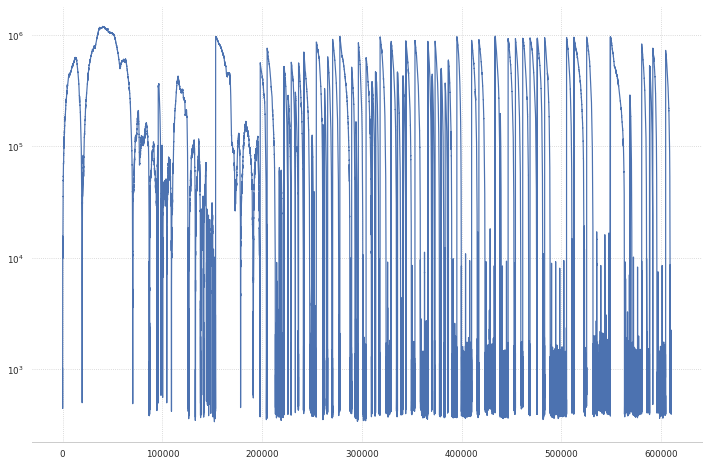

In [103]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
ax.plot(foo["index"], foo["Latency in us"])
plt.yscale("log")
# plt.savefig("exclusive_75_event_timeline")

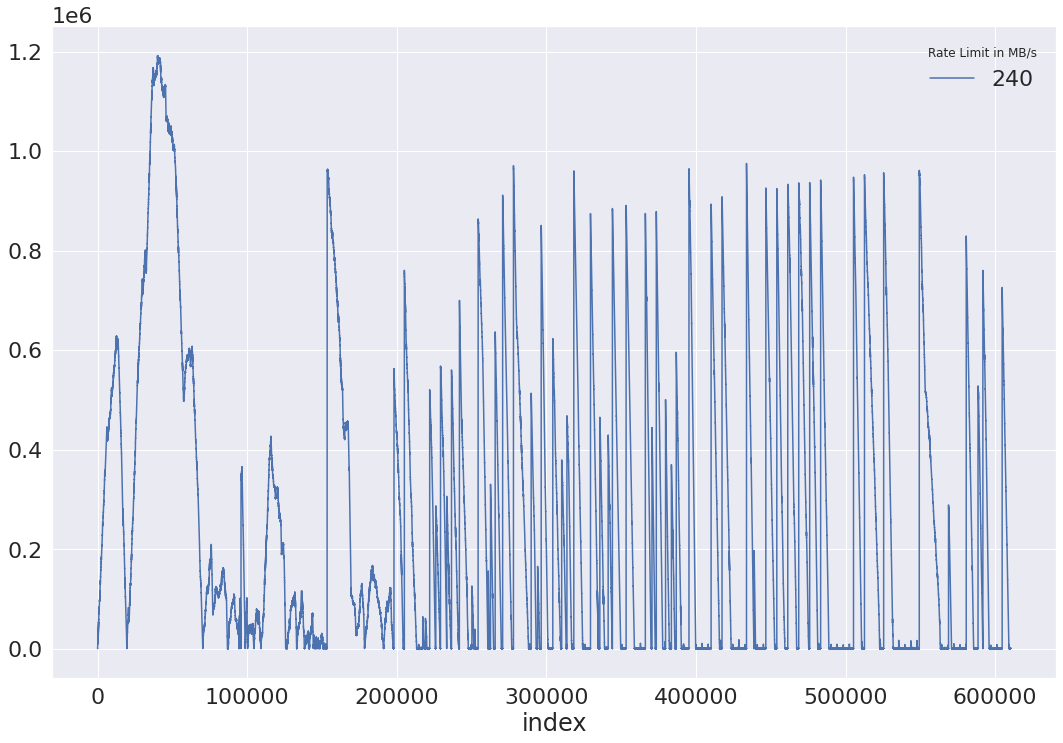

In [81]:
plot_timeseries(dataframes["kafka"]["event"][dataframes["kafka"]["event"]["Rate Limit in MB/s"] <= 240], "Latency in us")

## Ghostwriter Sustainable Throughput

In [63]:
dataframes = producer_dfs(log_directory + "20200727/processing_latency/")

In [64]:
dataframes["exclusive"]["event"].head()

,index,Latency in us,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,64,131072,90,3800
1,1,50,131072,90,3800
2,2,82,131072,90,3800
3,3,111,131072,90,3800
4,4,136,131072,90,3800


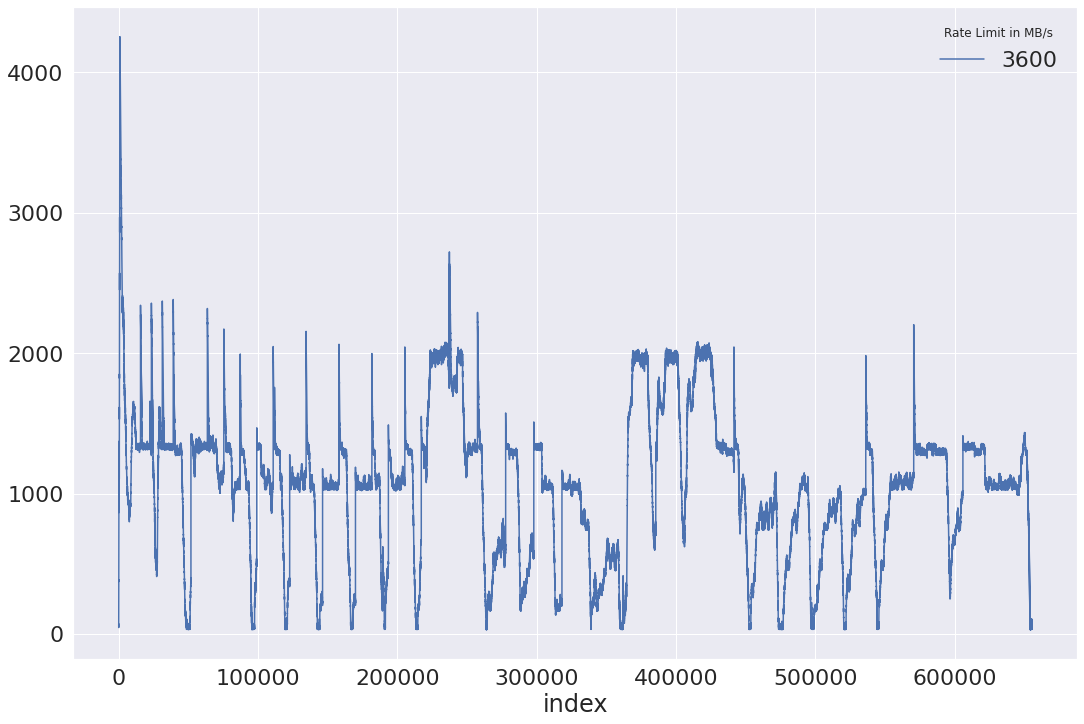

In [85]:
plot_timeseries(dataframes["exclusive"]["event"][dataframes["exclusive"]["event"]["Rate Limit in MB/s"] <= 3600], "Latency in us")

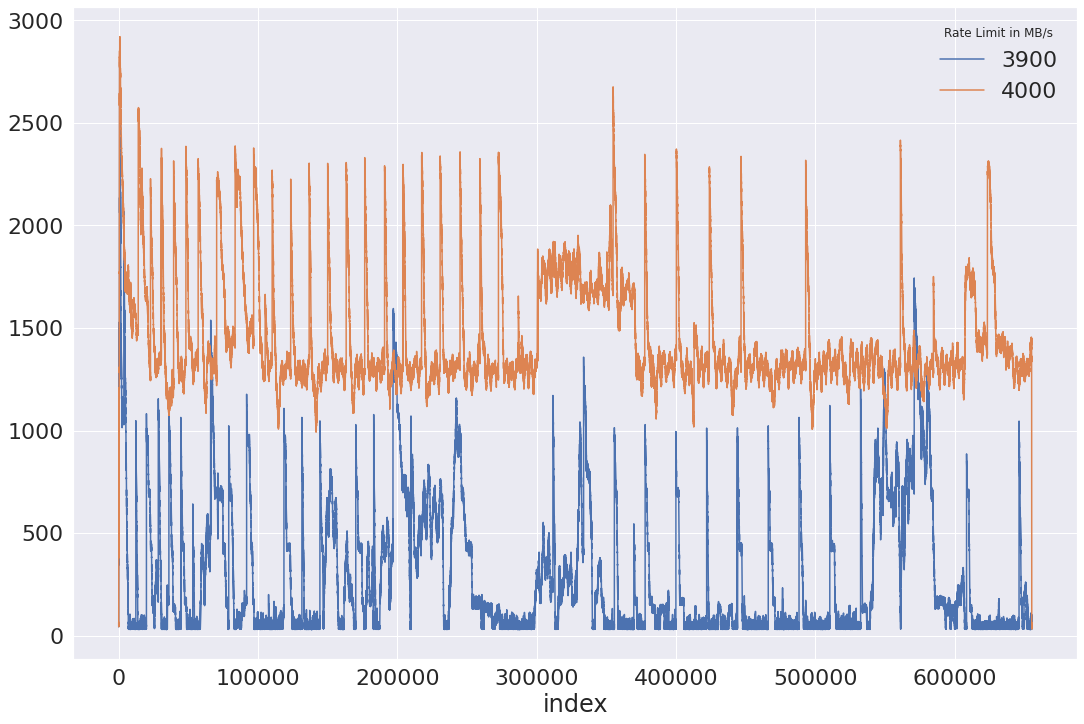

In [83]:
plot_timeseries(dataframes["exclusive_opt"]["event"][dataframes["exclusive_opt"]["event"]["Rate Limit in MB/s"] <= 4000], "Latency in us")

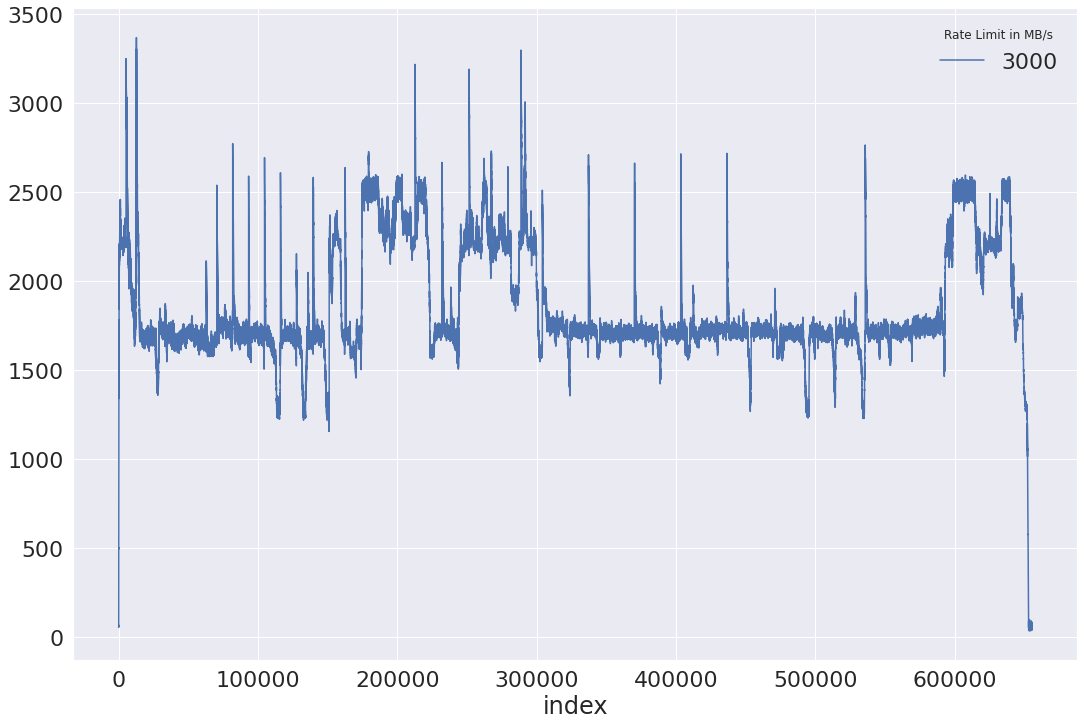

In [80]:
plot_timeseries(dataframes["concurrent"]["event"][dataframes["concurrent"]["event"]["Rate Limit in MB/s"] <= 3000], "Latency in us")

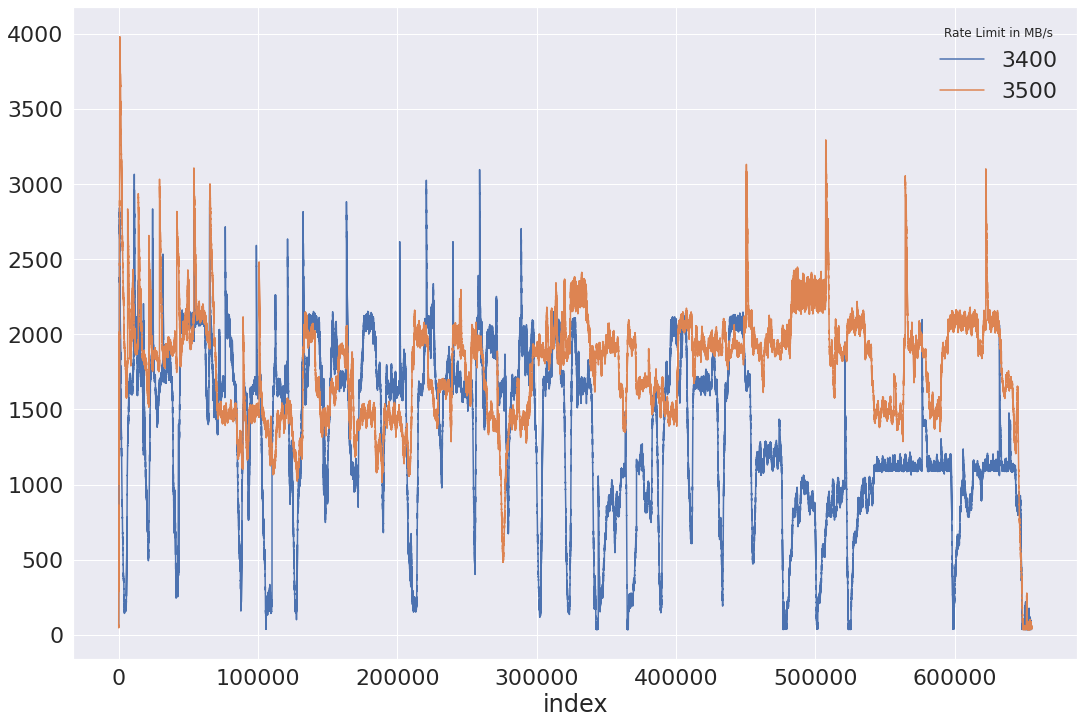

In [82]:
plot_timeseries(dataframes["concurrent_opt/10"]["event"][dataframes["concurrent_opt/10"]["event"]["Rate Limit in MB/s"] <= 3500], "Latency in us")

In [80]:
max_sust_tps[3].head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol
0,0,26892,3524.788,131072,90,3500,Concurrent Opt. (10)
1,1,27126,3555.459,131072,90,3500,Concurrent Opt. (10)
2,2,27022,3541.828,131072,90,3500,Concurrent Opt. (10)
3,3,27074,3548.643,131072,90,3500,Concurrent Opt. (10)
4,4,27043,3544.580,131072,90,3500,Concurrent Opt. (10)


In [8]:
def filter_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure][dataframes["exclusive"][measure]["Rate Limit in MB/s"] == 3600],
               dataframes["exclusive_opt"][measure][dataframes["exclusive_opt"][measure]["Rate Limit in MB/s"] == 4000],
               dataframes["concurrent"][measure][dataframes["concurrent"][measure]["Rate Limit in MB/s"] == 3000],
               dataframes["concurrent_opt/10"][measure][dataframes["concurrent_opt/10"][measure]["Rate Limit in MB/s"] == 3500]]
    df_list[0]["Protocol"] = "Exclusive"
    df_list[1]["Protocol"] = "Exclusive Opt."
    df_list[2]["Protocol"] = "Concurrent"
    df_list[3]["Protocol"] = "Concurrent Opt. (10)"
    return pd.concat(df_list)

In [90]:
max_sust_tps_df = filter_dfs(dataframes, "tp")

<ipython-input-89-77bd1d64317b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Exclusive"
<ipython-input-89-77bd1d64317b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Exclusive Opt."
<ipython-input-89-77bd1d64317b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

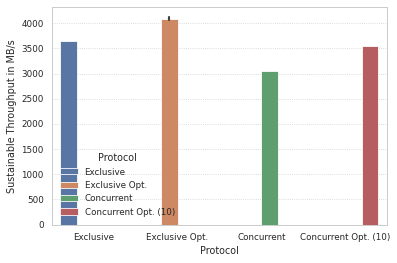

In [91]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Throughput in MB/s", hue="Protocol", data=max_sust_tps_df, ci="sd")
g.set_ylabel("Sustainable Throughput in MB/s")
g.get_figure().savefig("ghostwriter_sustainable_throughput", bbox_inches="tight", dpi=600)

In [92]:
max_event_lat_df = filter_dfs(dataframes, "event")
max_event_lat_df.head()

<ipython-input-89-77bd1d64317b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Exclusive"
<ipython-input-89-77bd1d64317b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Exclusive Opt."
<ipython-input-89-77bd1d64317b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,index,Latency in us,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol
0,0,74,131072,90,3600,Exclusive
1,1,47,131072,90,3600,Exclusive
2,2,87,131072,90,3600,Exclusive
3,3,105,131072,90,3600,Exclusive
4,4,125,131072,90,3600,Exclusive


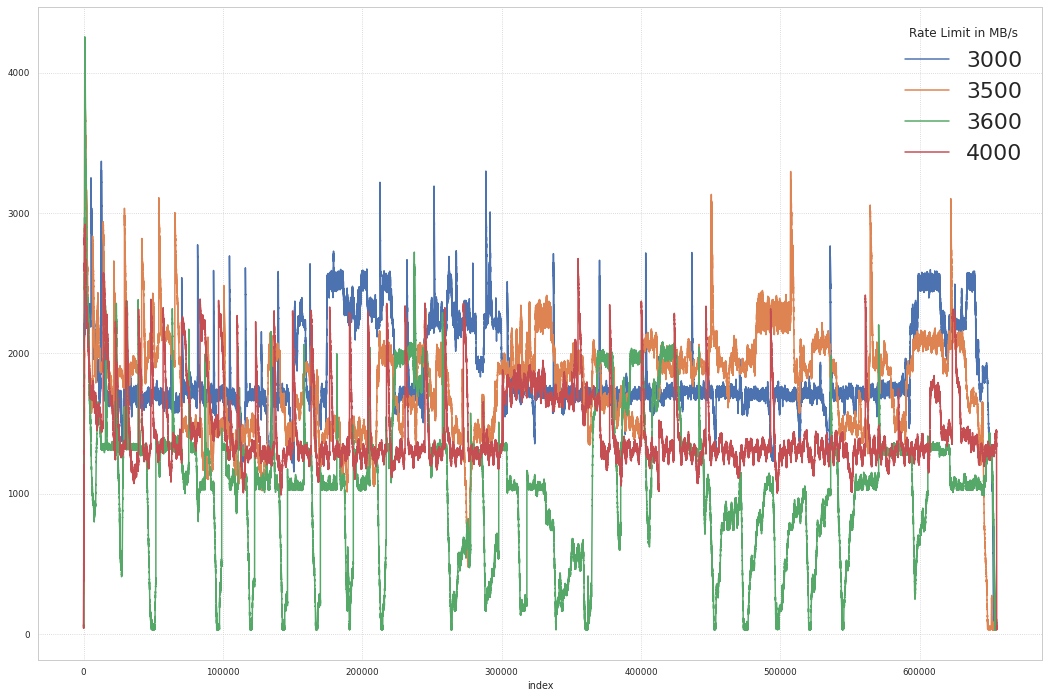

In [93]:
plot_timeseries(max_event_lat_df, "Latency in us")

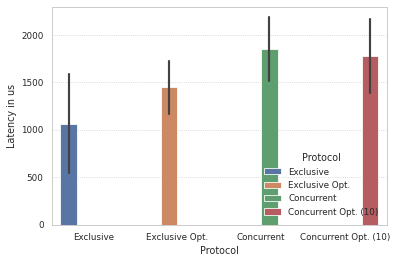

In [94]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=max_event_lat_df, ci="sd")
g.get_figure().savefig("ghostwriter_event_latency_100", bbox_inches="tight", dpi=600)

# Different Load Factors

In [95]:
dataframes_75 = producer_dfs(log_directory + "20200727/processing_latency/75/")

In [9]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt/10"][measure]]
    df_list[0]["Protocol"] = "Exclusive"
    df_list[1]["Protocol"] = "Exclusive Opt."
    df_list[2]["Protocol"] = "Concurrent"
    df_list[3]["Protocol"] = "Concurrent Opt. (10)"
    return pd.concat(df_list)

In [99]:
event_lat_75_df = prepare_dfs(dataframes_75, "event")

In [10]:
def prepare_plottable(measure):
    df_100 = filter_dfs(producer_dfs(log_directory + "20200727/processing_latency/"), measure)
    df_75 = prepare_dfs(producer_dfs(log_directory + "20200727/processing_latency/75/"), measure)
    df_50 = prepare_dfs(producer_dfs(log_directory + "20200727/processing_latency/50/"), measure)
    df_100["Load Factor"] = "100%"
    df_75["Load Factor"] = "75%"
    df_50["Load Factor"] = "50%"
    return pd.concat([df_100, df_75, df_50])

In [11]:
event_lat_df = prepare_plottable("event")

<ipython-input-8-77bd1d64317b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Exclusive"
<ipython-input-8-77bd1d64317b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Exclusive Opt."
<ipython-input-8-77bd1d64317b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

<Figure size 432x288 with 0 Axes>

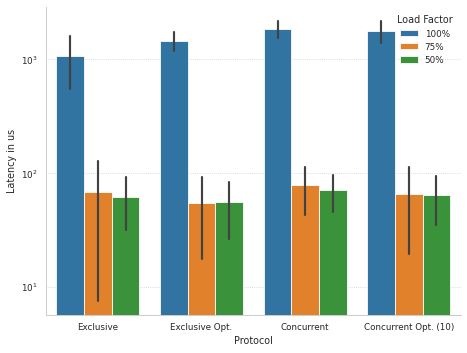

In [13]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.catplot(x="Protocol", y="Latency in us", hue="Load Factor", data=event_lat_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
g.set(yscale="log")
g.savefig("publishing_event_latency.png")

<ipython-input-8-77bd1d64317b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Exclusive"
<ipython-input-8-77bd1d64317b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Exclusive Opt."
<ipython-input-8-77bd1d64317b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

<Figure size 432x288 with 0 Axes>

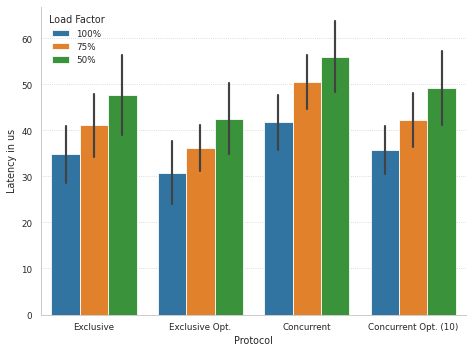

In [15]:
processing_lat_df = prepare_plottable("processing")
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.catplot(x="Protocol", y="Latency in us", hue="Load Factor", data=processing_lat_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
# g.set(yscale="log")
g.savefig("publishing_processing_latency.png")

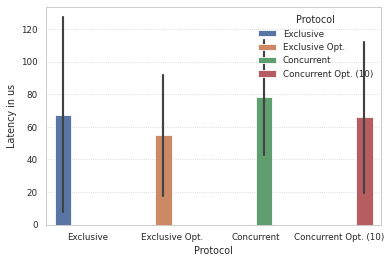

In [101]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=event_lat_75_df, ci="sd")
# g.get_figure().savefig("ghostwriter_event_latency_100", bbox_inches="tight", dpi=600)

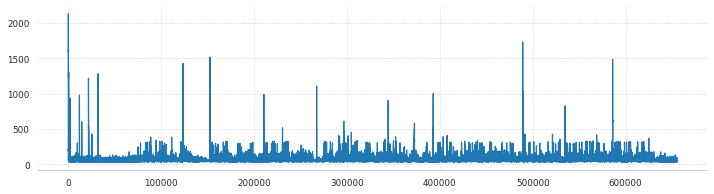

In [43]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = event_lat_df[event_lat_df["Load Factor"] == "75%"]
df = df[df["Protocol"] == "Exclusive"]
ax.plot(df["index"], df["Latency in us"])
# plt.yscale("log")
plt.savefig("exclusive_75_event_timeline")

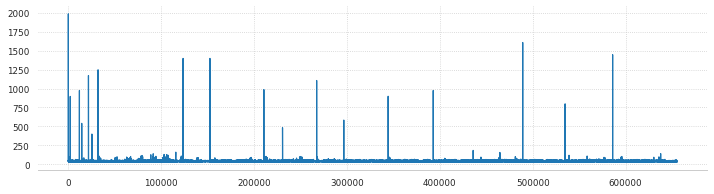

In [44]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = processing_lat_df[processing_lat_df["Load Factor"] == "75%"]
df = df[df["Protocol"] == "Exclusive"]
ax.plot(df["index"], df["Latency in us"])
# plt.yscale("log")
plt.savefig("exclusive_75_processing_timeline")

In [40]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
#     sns.set(font_scale=2)
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [63]:
def plot_comp_histogram(exclusive_df, exclusive_opt_df, measure, filename):
    exclusive_df["Broker"] = "Naive"
    exclusive_opt_df["Broker"] = "Optimized"
    df = pd.concat([exclusive_df, exclusive_opt_df])
    fig, ax = plt.subplots()
    sns.set_context('paper')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y=measure, hue="Broker", data=df, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    g.set_ylabel("Avg. " + measure)
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
    fig.savefig(filename, bbox_inches="tight", dpi=600)

# Consumer Latency

In [16]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [17]:
def consumer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_throughput.csv"))
        variant_dfs["latency"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    return result

In [19]:
cons_dfs = consumer_dfs(log_directory + "20200727/processing_latency/")

In [20]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt"][measure]]
    df_list[0]["Protocol"] = "Exclusive"
    df_list[1]["Protocol"] = "Exclusive Opt."
    df_list[2]["Protocol"] = "Concurrent"
    df_list[3]["Protocol"] = "Concurrent Opt."
    return pd.concat(df_list)

In [21]:
cons_df = prepare_dfs(cons_dfs, "latency")

In [22]:
cons_df.head()

,index,Latency in us,Message Size in Bytes,Protocol
0,0,26,131072,Exclusive
1,1,25,131072,Exclusive
2,2,25,131072,Exclusive
3,3,24,131072,Exclusive
4,4,24,131072,Exclusive


<Figure size 432x288 with 0 Axes>

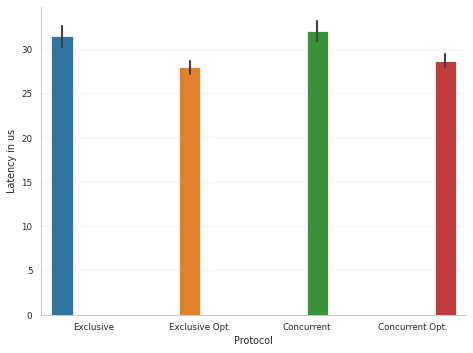

In [23]:
# fig_dims = (16, 3)
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
# g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=cons_df, ci="sd")
g = sns.catplot(x="Protocol", y="Latency in us", hue="Protocol", data=cons_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
# ax.plot(cons_df["index"], cons_df["Latency in us"])
# plt.yscale("log")
g.savefig("consumer_latency.png")